In [1]:
import os
import numpy as np
import pandas as pd
from scipy.linalg import hadamard
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Part 2

## Question 2 - Hadamard, Hadamard-Walsh, and Haar matrices

### a - implement $H_{2^n}$

In [2]:
def calc_kron_prod(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    ''' Calculate the Kroniker product between two matrices A, B '''
    if a.ndim == 0 or b.ndim == 0:
        return np.multiply(a,b)
    a_shape, b_shape = a.shape, b.shape
    res_shape = (a_shape[0] * b_shape[0], a_shape[1] * b_shape[1])
    res_mat = np.zeros(shape=res_shape)
    for i in range(res_shape[0]):
        for j in range(res_shape[1]):
            a_element = a[i // b_shape[0], j // b_shape[1]]
            b_element = b[i % b_shape[0], j % b_shape[1]]
            res_mat[i, j] = a_element * b_element
    return res_mat

In [44]:
def create_hadamard(n: int, normalized=True):
    '''
    Creates a Hadamard matrix using recursion of order 2^n and return it.
    '''
    c = 1
    if normalized:
        c = 1 / np.sqrt(2)
    if n == 1:
        return c * np.array([[1, 1], [1, -1]])
    return calc_kron_prod(create_hadamard(1), create_hadamard(n-1))

In [45]:
def test_kron(a, b):
    assert np.equal(np.kron(a, b), calc_kron_prod(a, b))

In [46]:
def test_hadamard(n):
    np.testing.assert_equal(hadamard(2**n), create_hadamard(n))

### b - plotting $\{h_i (t)\}^{2^n}_{i=1}$

In [48]:
hadamard_mats = []
for n in range(2, 7):
    hadamard_mats.append(create_hadamard(n)) # no need to transpose, Hadamard is symetrical

In [49]:
# Unused - returns vector of mapping
def create_interval_mapping(n):
    N = np.power(2, n)
    interval_size = 1 / N
    res = []
    for idx in range(N):
        res.append(lambda t: idx * interval_size <= t and t < (idx+1) * interval_size)
        print(f'{idx * interval_size=} {(idx+1) * interval_size=}')
    return res

In [50]:
def get_interval_mapping(n, interval_idx, t):
    N = np.power(2, n)
    interval_size = 1 / N
    is_in_interval = (float(interval_idx) * interval_size <= t and t < float(interval_idx + 1) * interval_size)
    return np.sqrt(N) * is_in_interval

In [71]:
def calc_hadamard_basis(n, hadamard_idx, num_samples):
    N = np.power(2, n)
    x_vals, y_vals = [], []
    offset = 2
    hadamard_mat = hadamard_mats[n - offset] # - offset=2?
    for k in range(num_samples):
        t = float(k) / num_samples
        x_vals.append(t)
        y_val = 0
        for interval_idx in range(N):
            y_val += hadamard_mat[interval_idx, hadamard_idx - 1] * get_interval_mapping(n=n, interval_idx=interval_idx, t=t)
        y_vals.append(y_val)
    fig_name = fr'Value of $h_{hadamard_idx}(t)$ for n = {n}'
    return x_vals, y_vals, fig_name

In [119]:
def create_function_figures(n, func, num_samples, figs_in_row=4, y_label='h', y_lim=[-2, 2]):
    N = np.power(2, n)
    figs_in_col = N // figs_in_row
    fig, axs = plt.subplots(nrows=figs_in_col, ncols=figs_in_row, squeeze=False, sharex = True, sharey = True)
    fig.set_figheight(figs_in_col * 3)
    fig.set_figwidth(figs_in_row * 4)
    plt.ylim(y_lim)
    plt.xlim([0, 1])
    func_idx = 1
    for col in range(figs_in_col):
        for row in range(figs_in_row):
            x_vals, y_vals, fig_name = func(n, func_idx, num_samples)
            x_s = np.arange(0.0, 1.2, 1.0 / num_samples)
            for interval_idx, y_val in enumerate(y_vals):
                axs[col, row].axhline(y_val, x_s[interval_idx], x_s[interval_idx+1])
            axs[col, row].set_title(fig_name)
            axs[col, row].grid()
            axs[col, row].set(xlabel='t', ylabel=fr'${y_label}_{func_idx+1}(t)$')
            func_idx += 1

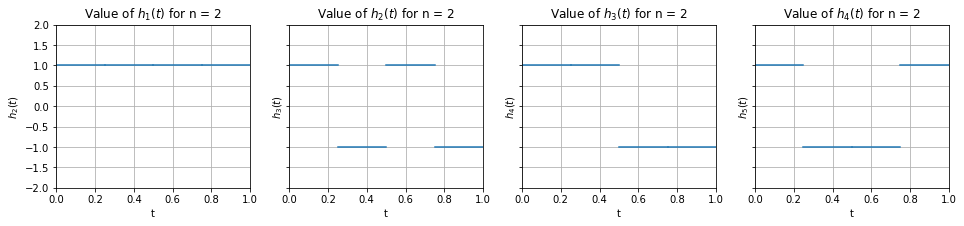

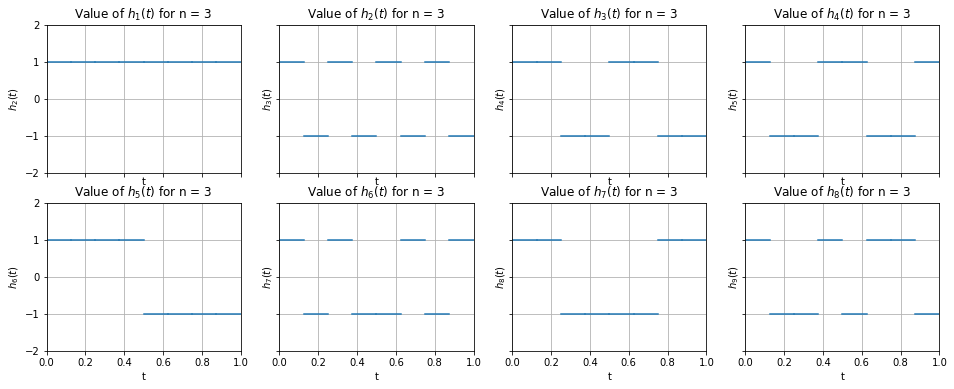

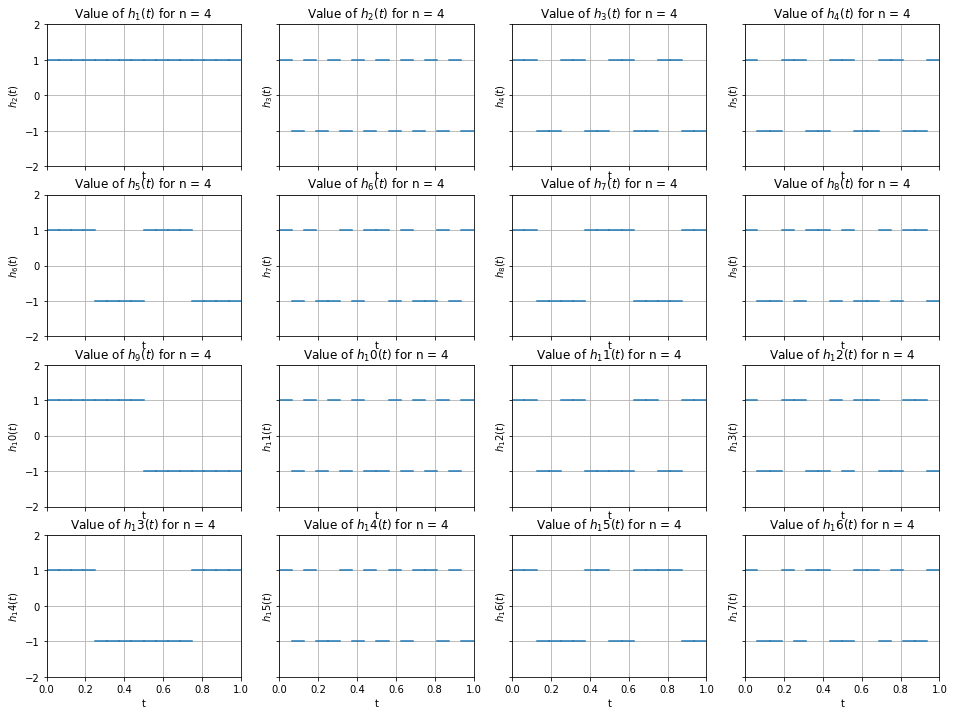

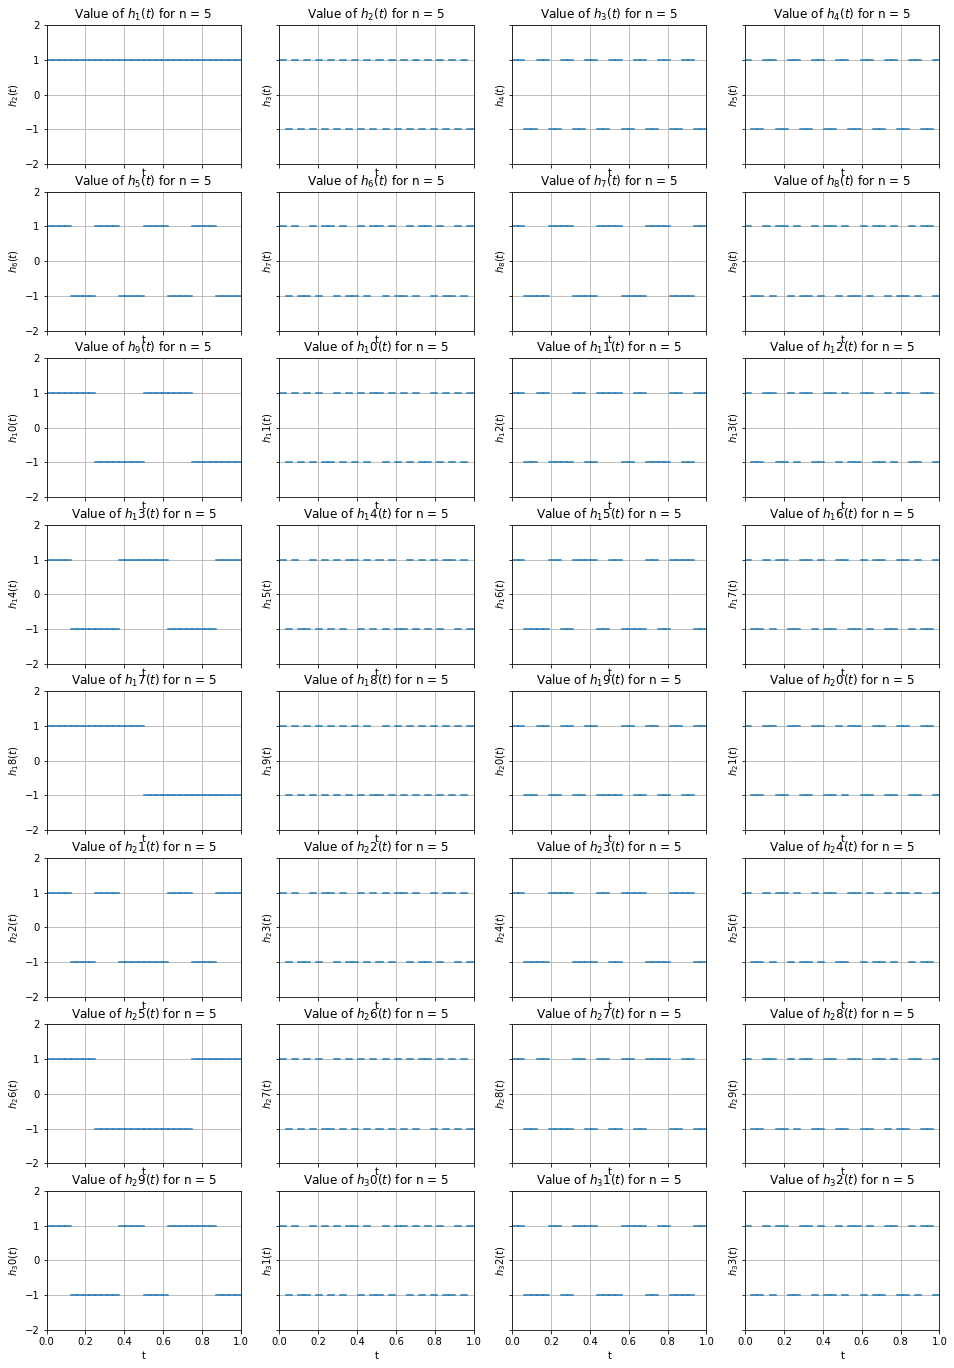

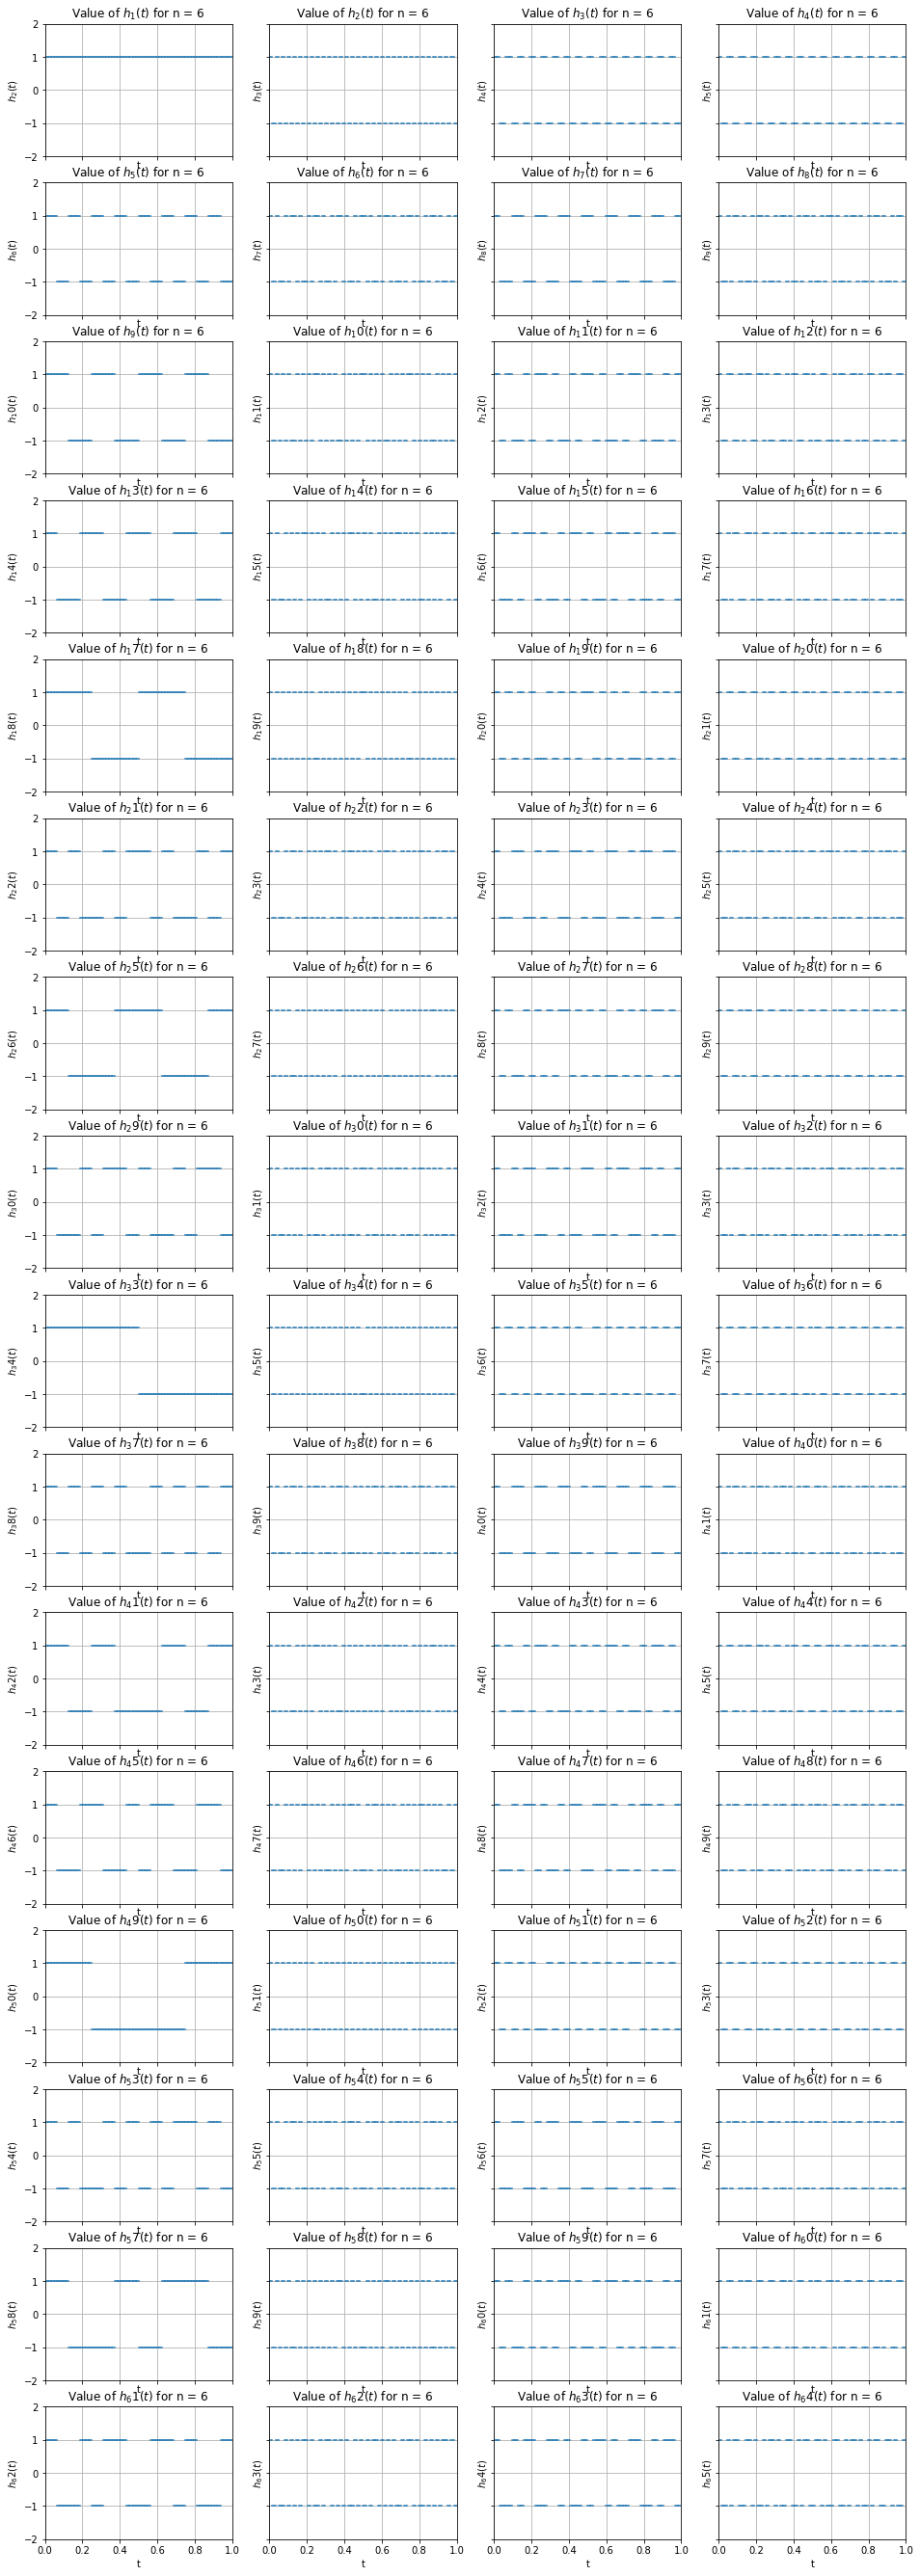

In [101]:
for n in range(2, 7):
    N = np.power(2, n)
    create_function_figures(n, func=calc_hadamard_basis, num_samples=N, y_label='h')

### c - Implementing Walsh Hadamard matrices $\tilde{H}_{2^n}$

In [102]:
def calc_sign_changes(m: np.ndarray):
    rows = m.shape[0]
    cols = m.shape[1]
    permutations = []
    for row in range(rows):
        sign_changes = 0
        e = m[row][0]
        for col in range(1, cols):
            if m[row][col] == -e:
                sign_changes += 1
                e = m[row][col]
        permutations.append((row, sign_changes))
    return permutations

def create_walsh_hadamard(H: np.ndarray):
    '''
    This function takes a Hadamard 2^n matrix and returns a 2^n x 2^n matrix
    '''
    WH = H.copy()
    perms = calc_sign_changes(WH)
    perms.sort(key=lambda e: e[1])
    for orig, (line, p) in enumerate(perms):
        WH[orig] = H[line]
    return WH
    

### d - plotting $\{wh_i (t)\}^{2^n}_{i=1}$

In [103]:
walsh_hadamard_mats = []
for n in range(2, 7):
    walsh_hadamard_mats.append(create_walsh_hadamard(create_hadamard(n)))


In [104]:
def calc_walsh_hadamard_basis(n, wh_idx, num_samples):
    N = np.power(2, n)
    x_vals, y_vals = [], []
    offset = 2
    wh_mat = walsh_hadamard_mats[n - offset] # - offset=2?
    for k in range(num_samples):
        t = float(k) / num_samples
        x_vals.append(t)
        y_val = 0
        for interval_idx in range(N):
            y_val += wh_mat[interval_idx, wh_idx - 1] * get_interval_mapping(n=n, interval_idx=interval_idx, t=t)
        y_vals.append(y_val)
    fig_name = fr'Value of $wh_{wh_idx}(t)$ for n = {n}'
    return x_vals, y_vals, fig_name

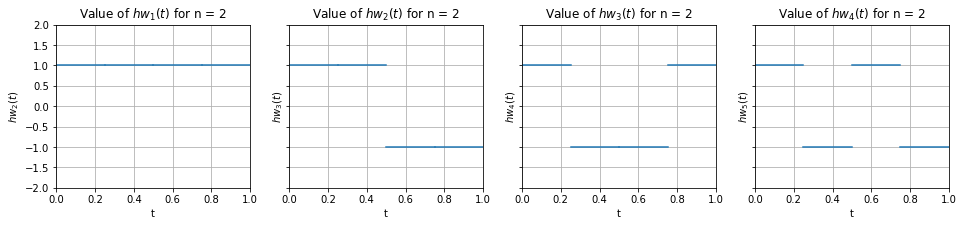

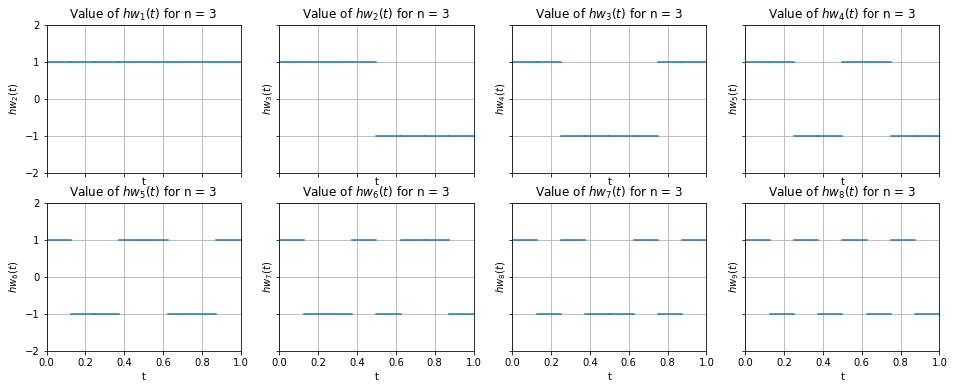

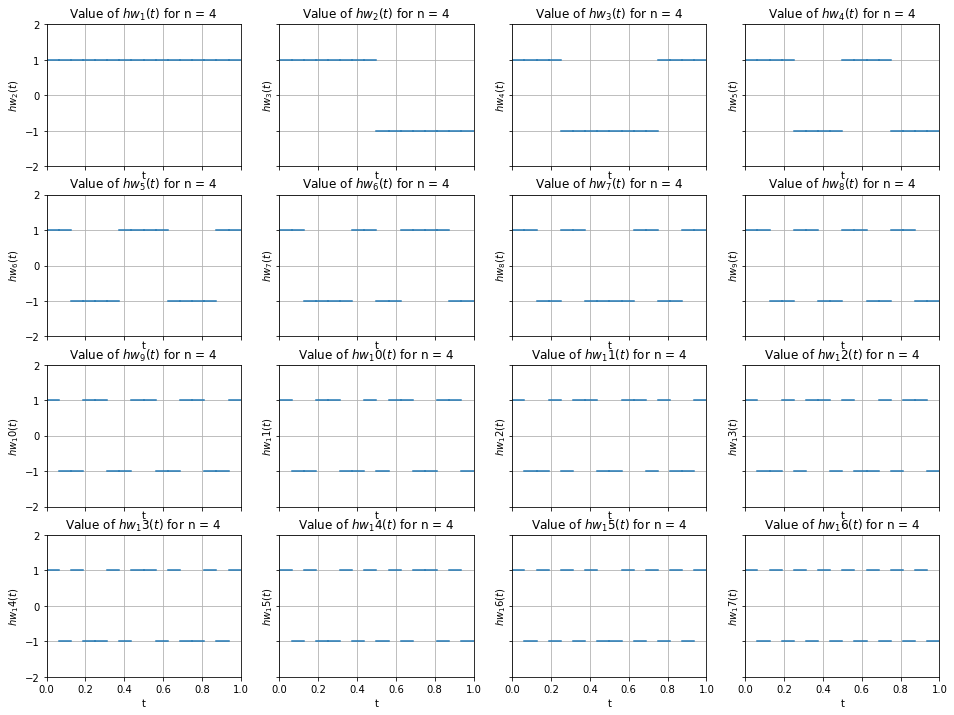

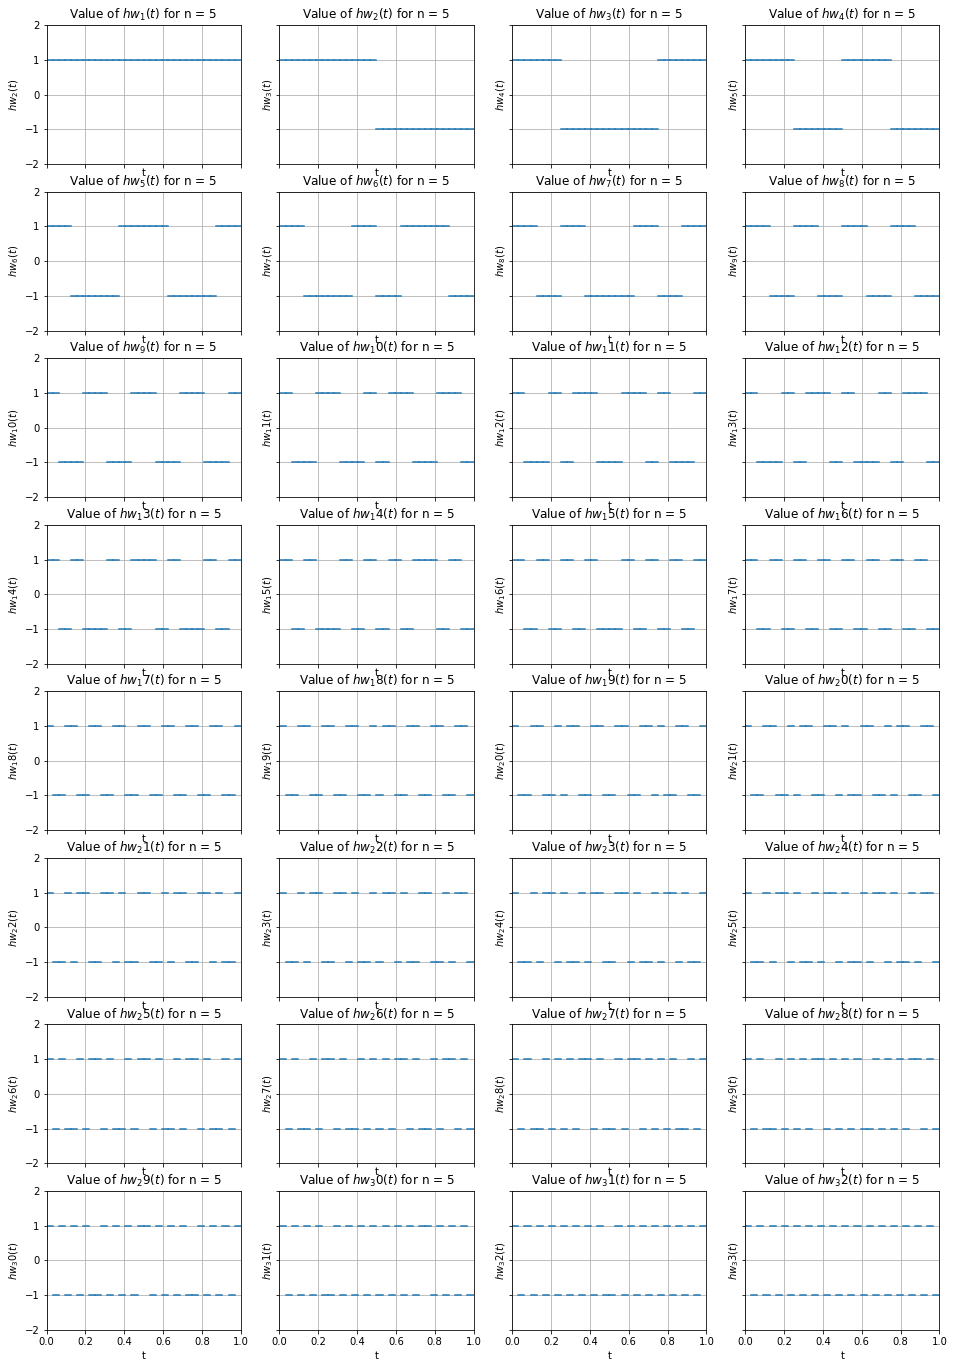

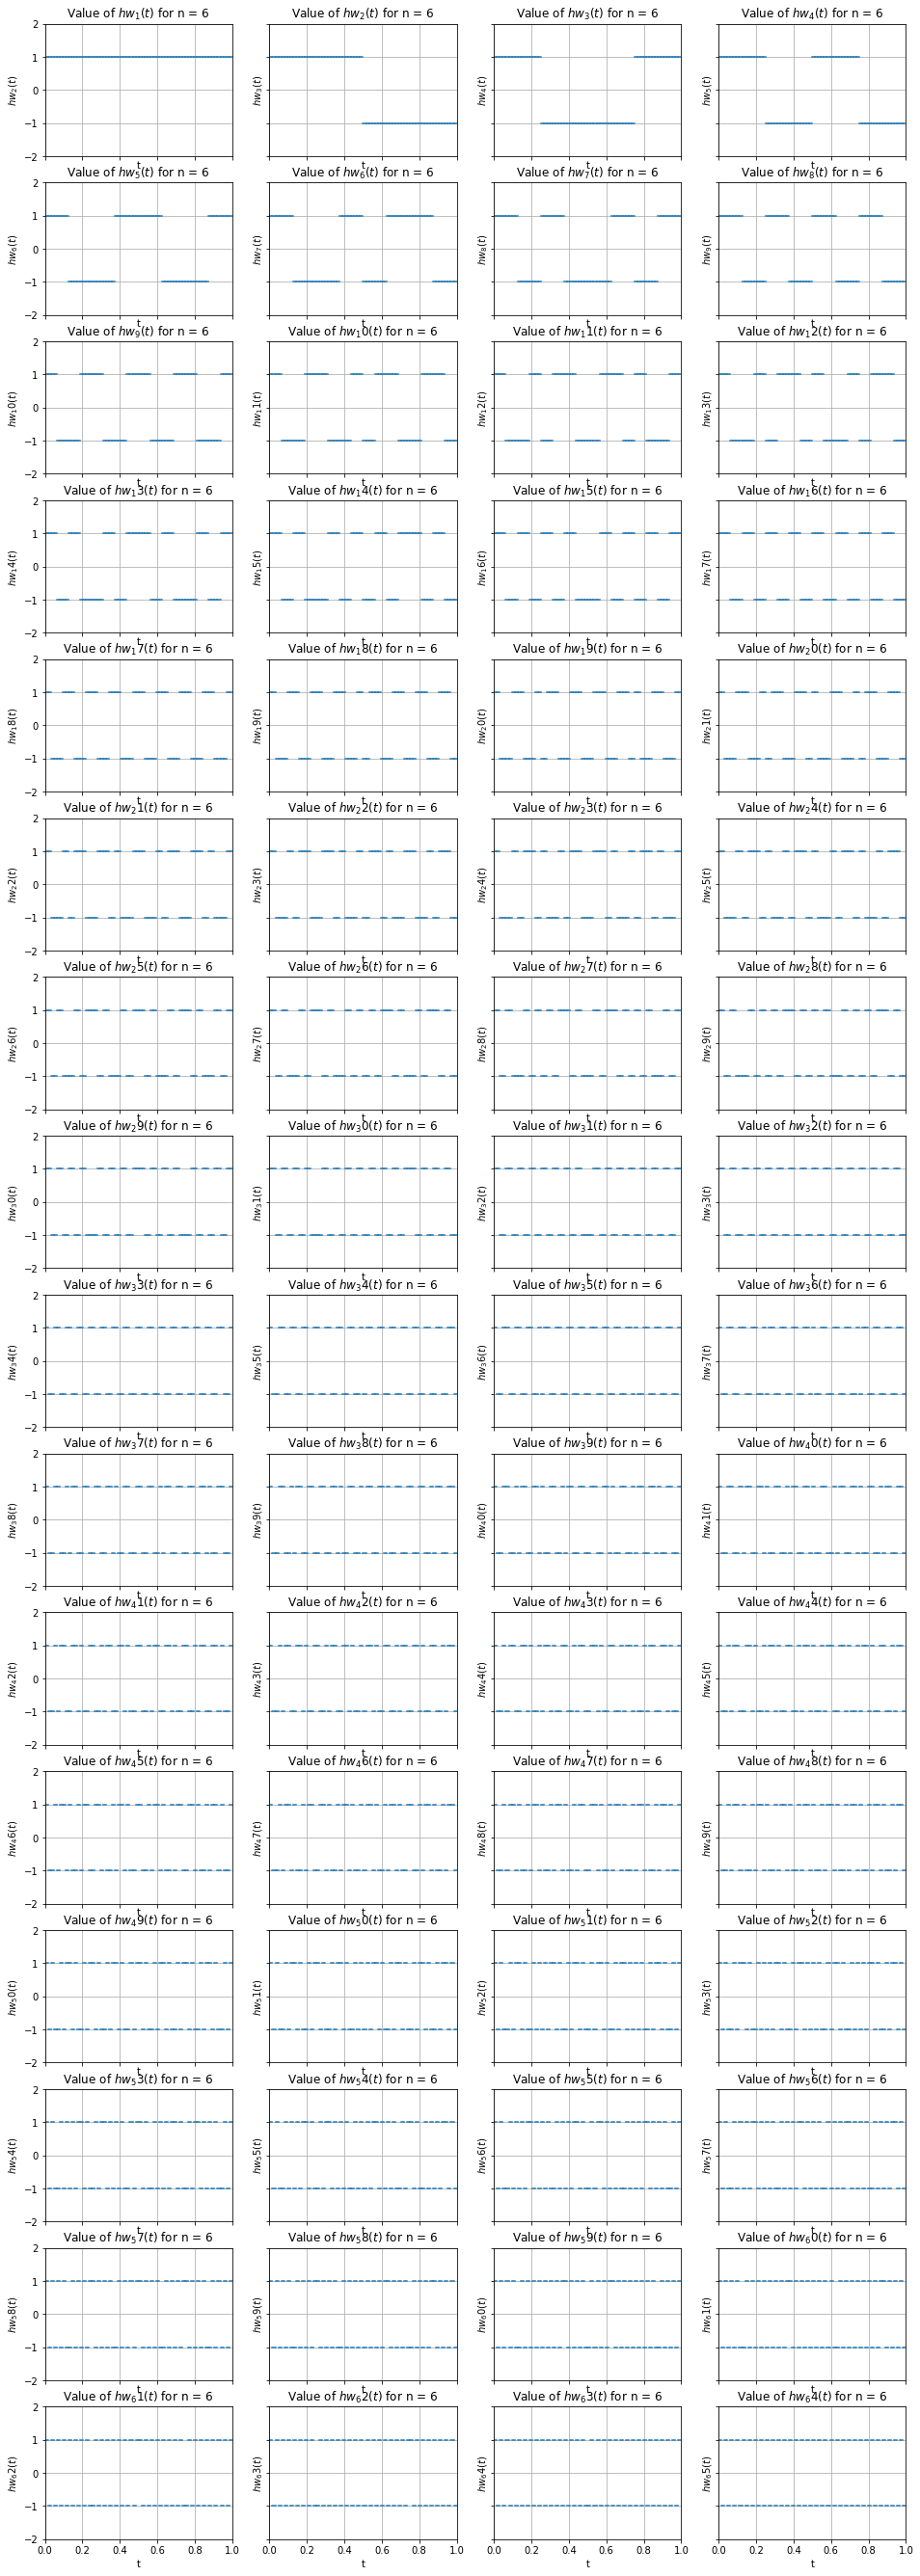

In [105]:
for n in range(2, 7):
    N = np.power(2, n)
    create_function_figures(n, func=calc_walsh_hadamard_basis, num_samples=N, y_label='wh')

### e - Implementing Haar matrices $\hat{H}_{2^n}$

In [112]:
def create_haar(n: int):
    '''
    Creates a Hadamard matrix using recursion of order 2^n and return it.
    '''
    if n == 1:
        return 1 / np.sqrt(2) *  np.array([[1, 1], [1, -1]])
    N = np.power(2, n)
    upper_haar = calc_kron_prod(create_haar(n-1), np.array([[1], [1]]))
    lower_haar = calc_kron_prod(np.eye(np.power(2, n-1)), np.array([[1], [-1]]))
    return 1 / np.sqrt(2) * np.concatenate([upper_haar, lower_haar], axis=1)

### f - plotting $\{ha_i (t)\}^{2^n}_{i=1}$

In [114]:
haar_mats = []
for n in range(2, 7):
    haar_mats.append(create_haar(n))

In [117]:
def calc_haar_basis(n, ha_idx, num_samples):
    N = np.power(2, n)
    x_vals, y_vals = [], []
    offset = 2
    haar_mat = haar_mats[n - offset] # - offset=2?
    for k in range(num_samples):
        t = float(k) / num_samples
        x_vals.append(t)
        y_val = 0
        for interval_idx in range(N):
            y_val += haar_mat[interval_idx, ha_idx - 1] * get_interval_mapping(n=n, interval_idx=interval_idx, t=t)
        y_vals.append(y_val)
    fig_name = fr'Value of $ha_{ha_idx}(t)$ for n = {n}'
    return x_vals, y_vals, fig_name

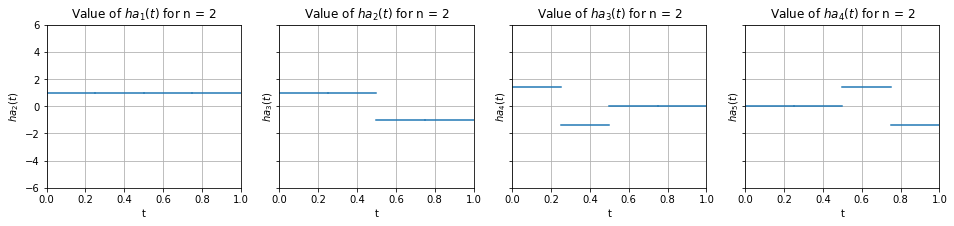

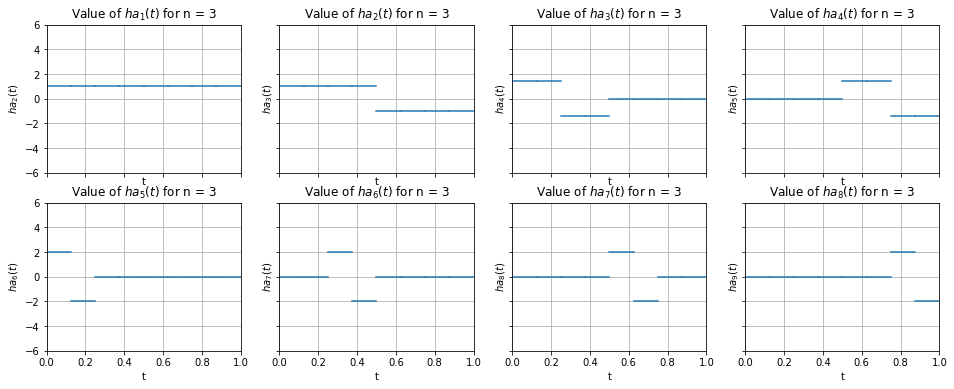

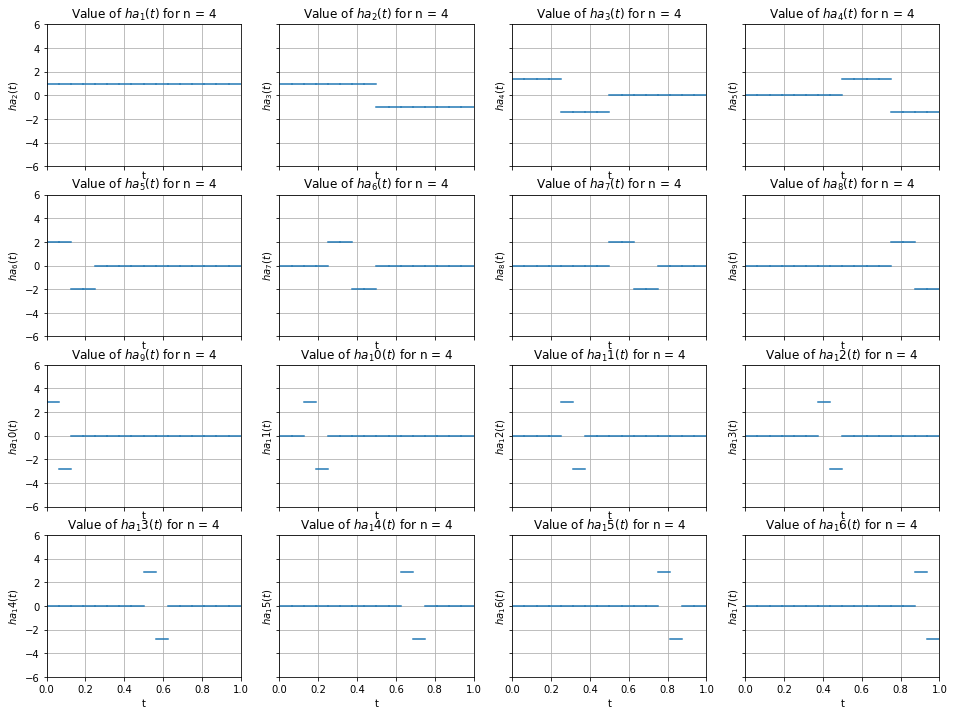

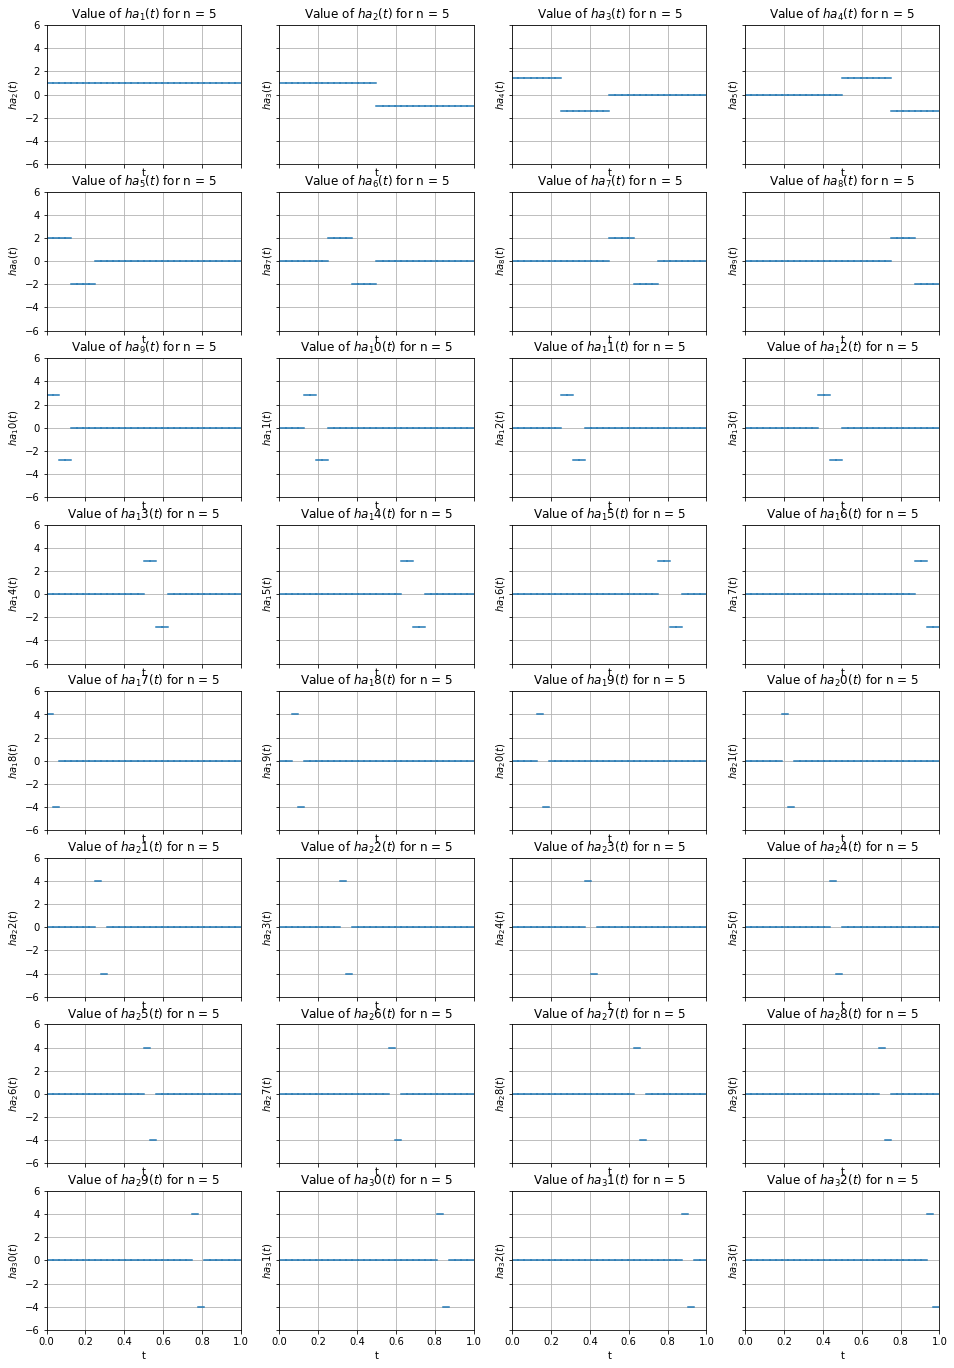

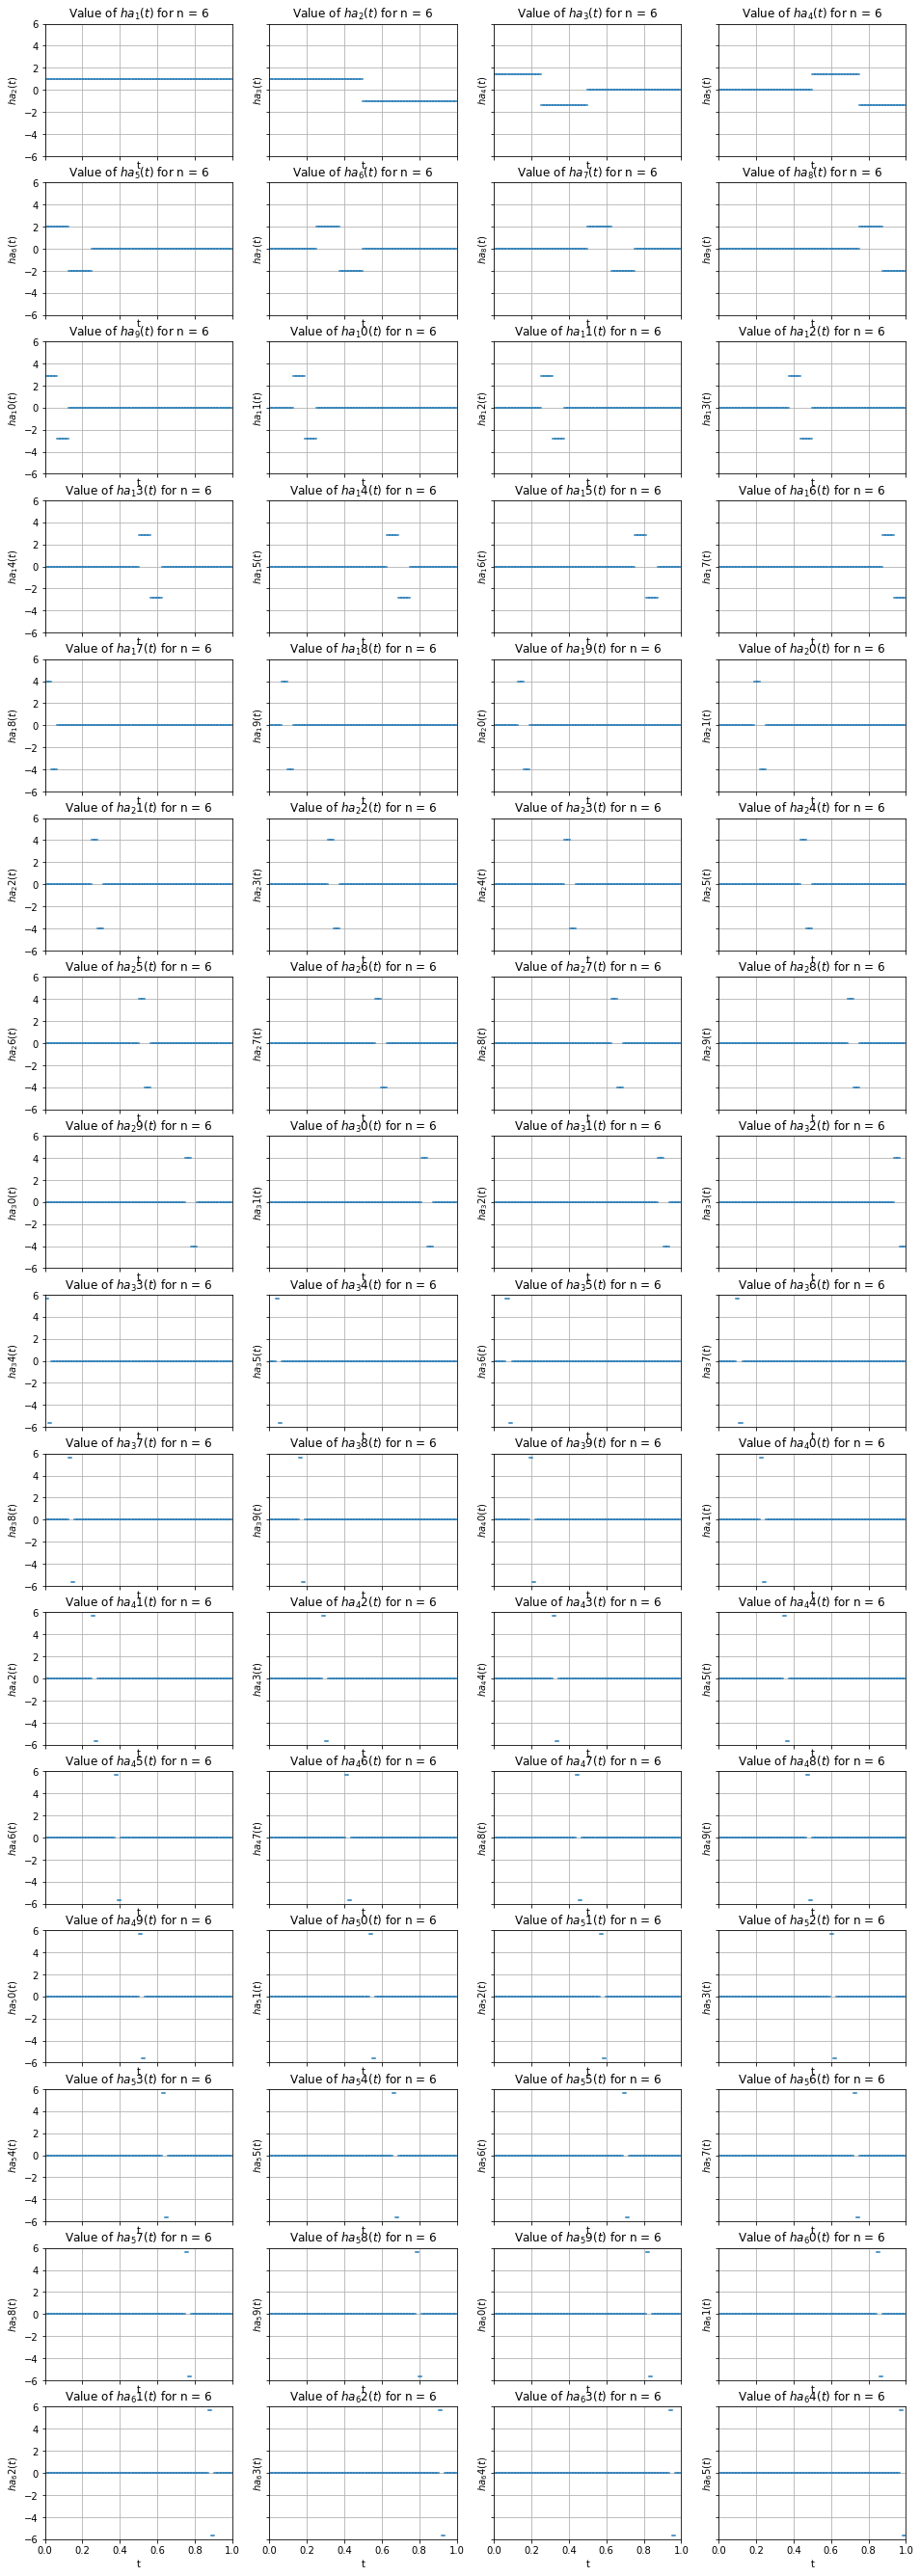

In [121]:
for n in range(2, 7):
    N = np.power(2, n)
    create_function_figures(n, func=calc_haar_basis, num_samples=N, y_label='ha', y_lim=[-6, 6])

### g
Given $t\in[-4,5]$, consider: $\phi(t)=t\cdot \exp(t)$
Consider $n=2$, we'll find the best $k$-term approx. of $\phi(t)$ for $k=1,\dots 2^n$

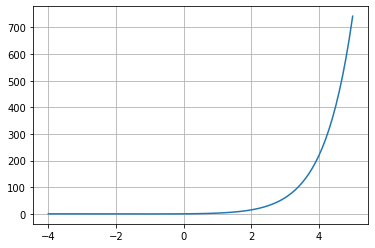

In [181]:
# We'll show the original function first
t = np.arange(-4, 5.1, 0.1)
plt.plot(t, t * np.exp(t))
plt.grid()
plt.show()

In [131]:
original_energy = 10.25 * (np.exp(10) - np.exp(-8))
delta = 9/4 # step size
k_max_terms = 4
x_lim = [-4.2, 5.2]

In [129]:
def calc_base_coeffs(base, t_lim=[-4, 5]):
    coeffs = []
    for v in base:
        coeff = 0
        for idx in range(4):
            low = t_lim[0] + idx * delta
            high = t_lim[0] + (idx + 1) * delta
            coeff += v[idx] * ((high-1) * np.exp(high) - (low-1) * np.exp(low))
        coeffs.append(coeff)
    return coeffs

In [143]:
def str_approx_error(coeffs_square_sum, k, fig_name):
    mse = original_energy - coeffs_square_sum
    return f'MSE of {k}-term approximation for base {fig_name} equals = {mse}'

In [144]:
def create_approx_figures(n, base, coeffs, k_term_order, y_lim, fig_name, figs_in_row=4):
    N = np.power(2, n)
    figs_in_col = N // figs_in_row
    fig, axs = plt.subplots(nrows=figs_in_col, ncols=figs_in_row, squeeze=False, sharex = True, sharey = True)
    fig.set_figheight(figs_in_col * 3)
    fig.set_figwidth(figs_in_row * 4)
    plt.ylim(y_lim)
    plt.xlim([0, 1])

    for col in range(figs_in_col):
        for row in range(k_max_terms): # also k term used
            func_approx = [0] * 4
            square_sum_base_coeffs = 0
            for k in range(row + 1):
                coeff_idx = k_term_order[k] - 1
                square_sum_base_coeffs += np.power(coeffs[coeff_idx], 2)
                
                # calculate approximation
                for i in range(N):
                    func_approx[i] += coeffs[coeff_idx] * base[coeff_idx][i]
            print(str_approx_error(square_sum_base_coeffs, row+1, fig_name))
            func_approx.append(func_approx[3])
            plt.ylim(y_lim)
            plt.xlim(x_lim)

            # create func approx figure
            x_vals = np.arange(-4, 5 + delta, delta)
            axs[col, row].step(x_vals, func_approx, where='post')
            axs[col, row].set_title(f'{row+1}-term approximation of {fig_name}')
            axs[col, row].grid()
            # plot original function over approximation
            t = np.arange(-4, 5.09, 0.1)
            axs[col, row].plot(t, t * np.exp(t), 'r')
            axs[col, row].set(xlabel='t', ylabel=r'$\phi(t)$')

Standard base:

MSE of 1-term approximation for base standard equals = 83250.91186720502
MSE of 2-term approximation for base standard equals = 82897.49777481775
MSE of 3-term approximation for base standard equals = 82897.43145134844
MSE of 4-term approximation for base standard equals = 82897.3780958027


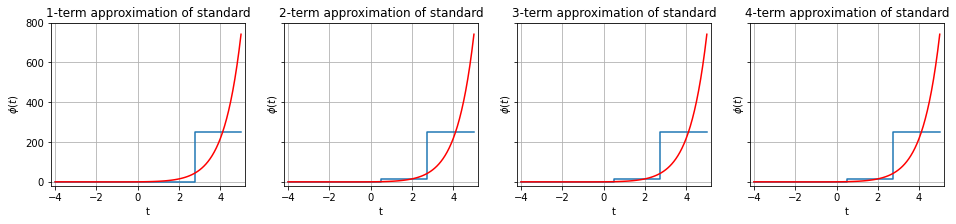

In [175]:
a = 2/3
standard_base = [[a,0,0,0],[0,a,0,0],[0,0,a,0],[0,0,0,a]]

standard_coeffs = calc_base_coeffs(standard_base)
term_order = list(zip(list(range(1, 5)), standard_coeffs))
term_order.sort(key = lambda k: np.abs(k[1]), reverse=True)

standard_k_order = [e[0] for e in term_order] # [4, 3, 1, 2]
create_approx_figures(n=2, base=standard_base, coeffs=standard_coeffs, k_term_order=standard_k_order, fig_name='standard', y_lim=[-20, 800])


Hadamard base

MSE of 1-term approximation for base Hadamard equals = 186407.41744756108
MSE of 2-term approximation for base Hadamard equals = 147237.1738501598
MSE of 3-term approximation for base Hadamard equals = 115062.51482711299
MSE of 4-term approximation for base Hadamard equals = 82897.37809580273


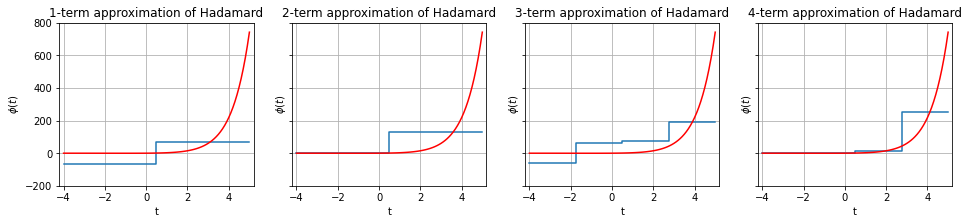

In [182]:
a = 4/12
hadamard_base = [[a,a,a,a],[a,-a,a,-a],[a,a,-a,-a],[a,-a,-a,a]]

hadamard_coeffs = calc_base_coeffs(hadamard_base)
term_order = list(zip(list(range(1, 5)), hadamard_coeffs))
term_order.sort(key = lambda k: np.abs(k[1]), reverse=True)

hadamard_k_order = [e[0] for e in term_order] # [3, 1, 2, 4]
create_approx_figures(n=2, base=hadamard_base, coeffs=hadamard_coeffs, k_term_order=hadamard_k_order, fig_name='Hadamard', y_lim=[-200, 800])


Walsh-Hadamard base

MSE of 1-term approximation for base WH equals = 186407.41744756108
MSE of 2-term approximation for base WH equals = 147237.1738501598
MSE of 3-term approximation for base WH equals = 115062.51482711299
MSE of 4-term approximation for base WH equals = 82897.37809580273


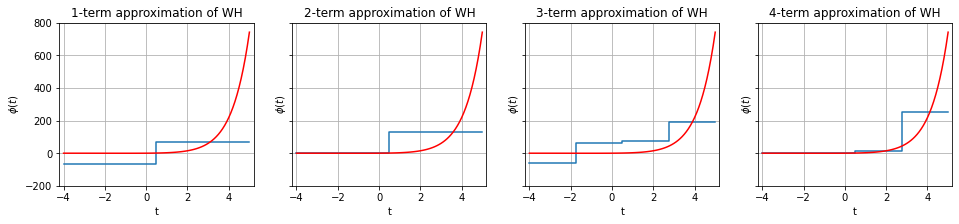

In [183]:
a = 4/12
wh_base = [[a,a,a,a],[a,a,-a,-a],[a,-a,-a,a],[a,-a,a,-a]]

wh_coeffs = calc_base_coeffs(wh_base)
term_order = list(zip(list(range(1, 5)), wh_coeffs))
term_order.sort(key = lambda k: np.abs(k[1]), reverse=True)

wh_k_order = [e[0] for e in term_order] # [2, 1, 4, 3]
create_approx_figures(n=2, base=wh_base, coeffs=wh_coeffs, k_term_order=wh_k_order, fig_name='WH', y_lim=[-200, 800])


Haar base

MSE of 1-term approximation for base Haar equals = 161431.47555624472
MSE of 2-term approximation for base Haar equals = 122067.62204552887
MSE of 3-term approximation for base Haar equals = 82897.3784481276
MSE of 4-term approximation for base Haar equals = 82897.37809580273


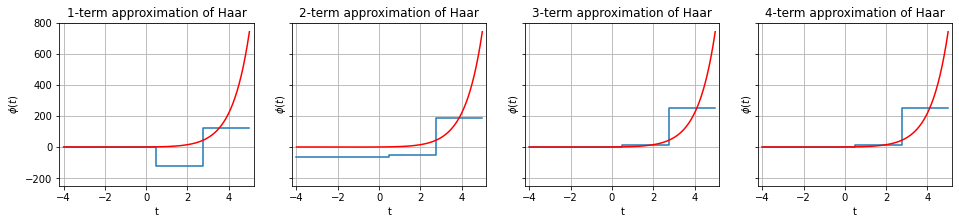

In [180]:
sr2 = np.sqrt(2)
a = 4/12
haar_base = [ [a, a, a, a], [a, a, -a, -a], [sr2*a, -sr2*a, 0, 0], [0, 0, sr2*a, -sr2*a] ]

haar_coeffs = calc_base_coeffs(haar_base)
term_order = list(zip(list(range(1, 5)), haar_coeffs))
term_order.sort(key = lambda k: np.abs(k[1]), reverse=True)
haar_k_order = [e[0] for e in term_order] # [4, 2, 1, 3]
create_approx_figures(n=2, base=haar_base, coeffs=haar_coeffs, k_term_order=haar_k_order, fig_name='Haar', y_lim=[-250, 800])
